In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

# Added
RATING_PRECISION=1 #one decimal

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [2]:
# read data from file
train = pd.read_csv("../input/train.csv") 
test = pd.read_csv("../input/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [3]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [4]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [5]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [6]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [7]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0].upper()) #added upper
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
            return int(test[0]) / 1024 # modified
        if test[1] == 'KB':
            return int(test[0]) / 1024 / 1024
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq1(test): #renamed and modified
    try:
        test = test.strip()
        test = test.split(' ')
        if test[3][:3].upper() == 'GHZ':
            if test[2][0] == '(':
                return float(test[2][1:])
            return float(test[2])
        elif test[3][:3].upper() == 'MHZ':
            if test[2][0] == '(':
                return float(test[2][1:]) / 1024
            return float(test[2]) / 1024
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_stringonly(test): # added new 
    try:
        test = test.strip()
        return (test.split(' ')[0].strip(' 0123456789').upper()) #added to strip numbers
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

In [8]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_Internal_Memory) #convert MB to GB
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    #data['RAM'][data['RAM'] == 0] = data['RAM'].median() # added
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_stringonly)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"
    data['Num_cores'][data['Num_cores'] == ''] = "Other" # added 


    data['Processor_frequency'] = data['Processor'].apply(find_freq1) #modified
    #because there is one entry with 208MHz values, to convert it to GHz
    #data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208 #added logic in find_freq1
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    data['Brand']=data['Brand'].apply(for_string) #added
    data['Brand'][data['Brand'].isna() == True] = "Other" # added
    data['Brand'][data['Brand'] == ''] = "Other" # added
    return data

In [9]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


Not very important feature

In [10]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [11]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [12]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)


combined_columns=['os_name','RAM','SIM Slot(s)','Sim1','Internal Memory','SIM 2','Num_cores','Brand'] #added
combined = pd.get_dummies(combined,columns=combined_columns) #modified
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Num_cores', 'os_name', 'RAM', 'SIM Slot(s)', 'Resolution',
       'Processor_frequency', 'Sim1', 'Screen Size', 'Weight', 'Height',
       'Capacity', 'Internal Memory', 'Brand', 'Pixel Density', 'SIM 2',
       'Screen to Body Ratio (calculated)'],
      dtype='object')
(460, 98)
Index(['PhoneId', 'Resolution', 'Processor_frequency', 'Screen Size', 'Weight',
       'Height', 'Capacity', 'Pixel Density',
       'Screen to Body Ratio (calculated)', 'os_name_ANDROID',
       'os_name_BLACKBERRY', 'os_name_IOS', 'os_name_KAI', 'os_name_NOKIA',
       'os_name_Other', 'os_name_TIZEN', 'RAM_0', 'RAM_1', 'RAM_2', 'RAM_3',
       'RAM_4', 'RAM_6', 'RAM_8', 'SIM Slot(s)_Dual SIM, GSM+CDMA',
       'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'Sim1_2G', 'Sim1_3G', 'Sim1_4G',
       'Internal Memory_0', 'Internal Memory_4', 'Internal Memory_8',
       'Internal Memory_16', 'Internal Memory_

In [13]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [14]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [15]:
train_new.head()

,PhoneId,Resolution,Processor_frequency,Screen Size,Weight,Height,Capacity,Pixel Density,Screen to Body Ratio (calculated),os_name_ANDROID,os_name_BLACKBERRY,os_name_IOS,os_name_KAI,os_name_NOKIA,os_name_Other,os_name_TIZEN,RAM_0,RAM_1,RAM_2,RAM_3,RAM_4,RAM_6,RAM_8,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Internal Memory_0,Internal Memory_4,Internal Memory_8,Internal Memory_16,Internal Memory_32,Internal Memory_64,Internal Memory_128,Internal Memory_256,Internal Memory_512,SIM 2_2G,...,Brand_GOOGLE,Brand_HONOR,Brand_HTC,Brand_HUAWEI,Brand_INFINIX,Brand_INFOCUS,Brand_INTEX,Brand_ITEL,Brand_IVOOMI,Brand_JIVI,Brand_KARBONN,Brand_LAVA,Brand_LEECO,Brand_LENOVO,Brand_LEPHONE,Brand_LG,Brand_LYF,Brand_MEIZU,Brand_MICROMAX,Brand_MOBIISTAR,Brand_MOTO,Brand_MOTOROLA,Brand_NOKIA,Brand_NUBIA,Brand_ONEPLUS,Brand_OPPO,Brand_PANASONIC,Brand_RAZER,Brand_REALME,Brand_RELIANCE,Brand_SAMSUNG,Brand_SONY,Brand_SPICE,Brand_TECNO,Brand_ULEFONE,Brand_VIVO,Brand_VOTO,Brand_XIAOMI,Brand_YU,Rating
0,0,20,1.8,6.26,182,157.9,4000,403,80.68,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.5
1,1,8,1.8,6.20,168,156.2,4230,271,80.85,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.5
2,2,25,2.1,6.30,168,157.0,3500,409,83.68,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.4
3,4,24,2.2,6.00,169,159.8,3300,411,74.78,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.3
4,5,16,2.2,6.50,175,160.4,3750,396,84.23,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.4


In [16]:
test_new.head()

,PhoneId,Resolution,Processor_frequency,Screen Size,Weight,Height,Capacity,Pixel Density,Screen to Body Ratio (calculated),os_name_ANDROID,os_name_BLACKBERRY,os_name_IOS,os_name_KAI,os_name_NOKIA,os_name_Other,os_name_TIZEN,RAM_0,RAM_1,RAM_2,RAM_3,RAM_4,RAM_6,RAM_8,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Internal Memory_0,Internal Memory_4,Internal Memory_8,Internal Memory_16,Internal Memory_32,Internal Memory_64,Internal Memory_128,Internal Memory_256,Internal Memory_512,SIM 2_2G,...,Brand_GIONEE,Brand_GOOGLE,Brand_HONOR,Brand_HTC,Brand_HUAWEI,Brand_INFINIX,Brand_INFOCUS,Brand_INTEX,Brand_ITEL,Brand_IVOOMI,Brand_JIVI,Brand_KARBONN,Brand_LAVA,Brand_LEECO,Brand_LENOVO,Brand_LEPHONE,Brand_LG,Brand_LYF,Brand_MEIZU,Brand_MICROMAX,Brand_MOBIISTAR,Brand_MOTO,Brand_MOTOROLA,Brand_NOKIA,Brand_NUBIA,Brand_ONEPLUS,Brand_OPPO,Brand_PANASONIC,Brand_RAZER,Brand_REALME,Brand_RELIANCE,Brand_SAMSUNG,Brand_SONY,Brand_SPICE,Brand_TECNO,Brand_ULEFONE,Brand_VIVO,Brand_VOTO,Brand_XIAOMI,Brand_YU
0,3,5,1.8,6.20,168,156.2,4230,271,80.85,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,11,12,1.8,6.20,205,156.0,5000,402,81.60,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13,25,2.0,6.30,169,156.7,3500,409,83.84,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16,16,2.0,6.30,169,156.7,3500,409,83.84,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19,20,1.8,5.99,181,158.6,4000,403,77.43,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# **My Model Code**

In [17]:
class MPNeuron:    
    def __init__(self,debug = 0):
        self.b=None
        self.debug=debug
    
    def log(self,x):
        if self.debug>0:
            print(x)
    
    def model(self,x):
        if sum(x) >= self.b:
            return 1
        else:
            return 0
    
    def predict(self,X):
        Y=[]
        for x in X:
            result = self.model(x)
            Y.append(result)
        return np.array(Y)
    
    def fit(self,X,Y):
        accuracy={}
        
        for b in range(X.shape[1]+1):
            self.b=b
            Y_pred=self.predict(X)
            accuracy[b]=accuracy_score(Y_pred,Y)
        
        best_b = max(accuracy, key=accuracy.get)
        self.b = best_b
        
        self.log(str('Value of b:' + str(best_b)))
        self.log(str('Accuracy:' + str(accuracy[best_b])))
        
        plt.plot(accuracy.values())
        plt.show()

In [18]:
train_new.describe()

,PhoneId,Resolution,Processor_frequency,Screen Size,Weight,Height,Capacity,Pixel Density,Screen to Body Ratio (calculated),os_name_ANDROID,os_name_BLACKBERRY,os_name_IOS,os_name_KAI,os_name_NOKIA,os_name_Other,os_name_TIZEN,RAM_0,RAM_1,RAM_2,RAM_3,RAM_4,RAM_6,RAM_8,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Internal Memory_0,Internal Memory_4,Internal Memory_8,Internal Memory_16,Internal Memory_32,Internal Memory_64,Internal Memory_128,Internal Memory_256,Internal Memory_512,SIM 2_2G,...,Brand_GOOGLE,Brand_HONOR,Brand_HTC,Brand_HUAWEI,Brand_INFINIX,Brand_INFOCUS,Brand_INTEX,Brand_ITEL,Brand_IVOOMI,Brand_JIVI,Brand_KARBONN,Brand_LAVA,Brand_LEECO,Brand_LENOVO,Brand_LEPHONE,Brand_LG,Brand_LYF,Brand_MEIZU,Brand_MICROMAX,Brand_MOBIISTAR,Brand_MOTO,Brand_MOTOROLA,Brand_NOKIA,Brand_NUBIA,Brand_ONEPLUS,Brand_OPPO,Brand_PANASONIC,Brand_RAZER,Brand_REALME,Brand_RELIANCE,Brand_SAMSUNG,Brand_SONY,Brand_SPICE,Brand_TECNO,Brand_ULEFONE,Brand_VIVO,Brand_VOTO,Brand_XIAOMI,Brand_YU,Rating
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,...,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,232.970674,9.592375,1.792551,5.462317,161.343109,149.946394,3191.307918,344.211144,72.353343,0.906158,0.005865,0.055718,0.005865,0.002933,0.020528,0.002933,0.029326,0.085044,0.196481,0.290323,0.275660,0.099707,0.023460,0.002933,0.759531,0.152493,0.085044,0.020528,0.020528,0.958944,0.002933,0.014663,0.064516,0.228739,0.325513,0.272727,0.076246,0.011730,0.002933,0.211144,...,0.011730,0.049853,0.017595,0.017595,0.008798,0.008798,0.011730,0.011730,0.002933,0.002933,0.005865,0.017595,0.002933,0.043988,0.002933,0.026393,0.002933,0.005865,0.043988,0.011730,0.043988,0.005865,0.061584,0.002933,0.008798,0.058651,0.011730,0.002933,0.011730,0.002933,0.129032,0.026393,0.0,0.023460,0.002933,0.076246,0.002933,0.070381,0.011730,4.072434
std,137.231746,5.953827,0.451598,0.742529,22.305556,9.192305,932.533527,88.161129,9.357839,0.292037,0.076471,0.229714,0.076471,0.054153,0.142006,0.054153,0.168965,0.279357,0.397920,0.454578,0.447503,0.300049,0.151583,0.054153,0.427996,0.360026,0.279357,0.142006,0.142006,0.198711,0.054153,0.120375,0.246031,0.420638,0.469255,0.446016,0.265782,0.107827,0.054153,0.408720,...,0.107827,0.217962,0.131668,0.131668,0.093520,0.093520,0.107827,0.107827,0.054153,0.054153,0.076471,0.131668,0.054153,0.205370,0.054153,0.160536,0.054153,0.076471,0.205370,0.107827,0.205370,0.076471,0.240751,0.054153,0.093520,0.235316,0.107827,0.054153,0.107827,0.054153,0.335728,0.160536,0.0,0.151583,0.054153,0.265782,0.054153,0.256164,0.107827,0.377066
min,0.000000,2.000000,1.000000,2.400000,58.000000,115.600000,1020.000000,143.000000,23.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [19]:
#Ignore this data as the values are of extreme limits
train_new = train_new[train_new['PhoneId'] != 224]

In [20]:
X_train=train_new.drop(['PhoneId'], axis=1)
X_train.head(10)

,Resolution,Processor_frequency,Screen Size,Weight,Height,Capacity,Pixel Density,Screen to Body Ratio (calculated),os_name_ANDROID,os_name_BLACKBERRY,os_name_IOS,os_name_KAI,os_name_NOKIA,os_name_Other,os_name_TIZEN,RAM_0,RAM_1,RAM_2,RAM_3,RAM_4,RAM_6,RAM_8,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Internal Memory_0,Internal Memory_4,Internal Memory_8,Internal Memory_16,Internal Memory_32,Internal Memory_64,Internal Memory_128,Internal Memory_256,Internal Memory_512,SIM 2_2G,SIM 2_3G,...,Brand_GOOGLE,Brand_HONOR,Brand_HTC,Brand_HUAWEI,Brand_INFINIX,Brand_INFOCUS,Brand_INTEX,Brand_ITEL,Brand_IVOOMI,Brand_JIVI,Brand_KARBONN,Brand_LAVA,Brand_LEECO,Brand_LENOVO,Brand_LEPHONE,Brand_LG,Brand_LYF,Brand_MEIZU,Brand_MICROMAX,Brand_MOBIISTAR,Brand_MOTO,Brand_MOTOROLA,Brand_NOKIA,Brand_NUBIA,Brand_ONEPLUS,Brand_OPPO,Brand_PANASONIC,Brand_RAZER,Brand_REALME,Brand_RELIANCE,Brand_SAMSUNG,Brand_SONY,Brand_SPICE,Brand_TECNO,Brand_ULEFONE,Brand_VIVO,Brand_VOTO,Brand_XIAOMI,Brand_YU,Rating
0,20,1.8,6.26,182,157.9,4000,403,80.68,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.5
1,8,1.8,6.20,168,156.2,4230,271,80.85,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.5
2,25,2.1,6.30,168,157.0,3500,409,83.68,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.4
3,24,2.2,6.00,169,159.8,3300,411,74.78,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.3
4,16,2.2,6.50,175,160.4,3750,396,84.23,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.4
5,25,2.2,6.41,156,157.9,3400,402,84.98,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.5
6,5,2.0,5.45,145,147.5,3000,295,72.68,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.3
7,5,2.0,5.84,178,149.3,4000,432,79.24,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.1
8,8,1.8,6.20,168,156.2,4230,271,80.85,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.3
9,20,2.8,6.18,182,155.5,4000,403,82.20,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.5


In [21]:
X_test=test_new.drop(['PhoneId'], axis=1)
X_test.head(10)

,Resolution,Processor_frequency,Screen Size,Weight,Height,Capacity,Pixel Density,Screen to Body Ratio (calculated),os_name_ANDROID,os_name_BLACKBERRY,os_name_IOS,os_name_KAI,os_name_NOKIA,os_name_Other,os_name_TIZEN,RAM_0,RAM_1,RAM_2,RAM_3,RAM_4,RAM_6,RAM_8,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Internal Memory_0,Internal Memory_4,Internal Memory_8,Internal Memory_16,Internal Memory_32,Internal Memory_64,Internal Memory_128,Internal Memory_256,Internal Memory_512,SIM 2_2G,SIM 2_3G,...,Brand_GIONEE,Brand_GOOGLE,Brand_HONOR,Brand_HTC,Brand_HUAWEI,Brand_INFINIX,Brand_INFOCUS,Brand_INTEX,Brand_ITEL,Brand_IVOOMI,Brand_JIVI,Brand_KARBONN,Brand_LAVA,Brand_LEECO,Brand_LENOVO,Brand_LEPHONE,Brand_LG,Brand_LYF,Brand_MEIZU,Brand_MICROMAX,Brand_MOBIISTAR,Brand_MOTO,Brand_MOTOROLA,Brand_NOKIA,Brand_NUBIA,Brand_ONEPLUS,Brand_OPPO,Brand_PANASONIC,Brand_RAZER,Brand_REALME,Brand_RELIANCE,Brand_SAMSUNG,Brand_SONY,Brand_SPICE,Brand_TECNO,Brand_ULEFONE,Brand_VIVO,Brand_VOTO,Brand_XIAOMI,Brand_YU
0,5,1.8,6.20,168,156.2,4230,271,80.85,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,12,1.8,6.20,205,156.0,5000,402,81.60,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,25,2.0,6.30,169,156.7,3500,409,83.84,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16,2.0,6.30,169,156.7,3500,409,83.84,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20,1.8,5.99,181,158.6,4000,403,77.43,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,24,1.8,6.00,191,160.2,3500,411,75.67,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,8,1.8,5.99,180,159.0,5000,403,76.62,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,5,2.0,5.45,146,147.5,3000,295,72.68,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,5,2.0,6.22,148,155.0,3260,270,82.66,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,8,1.6,5.60,154,149.3,3000,294,76.28,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [22]:
X_bin_train=X_train
X_bin_test=X_test


In [23]:
rating_bins = int((X_bin_train['Rating'].max() - X_bin_train['Rating'].min())/(0.1 *RATING_PRECISION)) + 1 #exlcude Zero
rating_threshold = int((THRESHOLD - X_bin_train['Rating'].min())/(0.1 *RATING_PRECISION)) # include Zero
print(rating_bins, rating_threshold)

26 15


In [24]:
column_cut_train=['Weight','Screen Size','Screen to Body Ratio (calculated)','Resolution','Pixel Density','Height','Capacity','Processor_frequency','Rating']
X_bin_train[column_cut_train] =X_train[column_cut_train].apply(pd.cut,bins=rating_bins,labels=list(range(rating_bins)))

column_cut_test=['Weight','Screen Size','Screen to Body Ratio (calculated)','Resolution','Pixel Density','Height','Capacity','Processor_frequency']
X_bin_test[column_cut_test] =X_test[column_cut_test].apply(pd.cut,bins=rating_bins,labels=list(range(rating_bins)))

In [25]:
X_bin_train.head()

,Resolution,Processor_frequency,Screen Size,Weight,Height,Capacity,Pixel Density,Screen to Body Ratio (calculated),os_name_ANDROID,os_name_BLACKBERRY,os_name_IOS,os_name_KAI,os_name_NOKIA,os_name_Other,os_name_TIZEN,RAM_0,RAM_1,RAM_2,RAM_3,RAM_4,RAM_6,RAM_8,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Internal Memory_0,Internal Memory_4,Internal Memory_8,Internal Memory_16,Internal Memory_32,Internal Memory_64,Internal Memory_128,Internal Memory_256,Internal Memory_512,SIM 2_2G,SIM 2_3G,...,Brand_GOOGLE,Brand_HONOR,Brand_HTC,Brand_HUAWEI,Brand_INFINIX,Brand_INFOCUS,Brand_INTEX,Brand_ITEL,Brand_IVOOMI,Brand_JIVI,Brand_KARBONN,Brand_LAVA,Brand_LEECO,Brand_LENOVO,Brand_LEPHONE,Brand_LG,Brand_LYF,Brand_MEIZU,Brand_MICROMAX,Brand_MOBIISTAR,Brand_MOTO,Brand_MOTOROLA,Brand_NOKIA,Brand_NUBIA,Brand_ONEPLUS,Brand_OPPO,Brand_PANASONIC,Brand_RAZER,Brand_REALME,Brand_RELIANCE,Brand_SAMSUNG,Brand_SONY,Brand_SPICE,Brand_TECNO,Brand_ULEFONE,Brand_VIVO,Brand_VOTO,Brand_XIAOMI,Brand_YU,Rating
0,20,11,23,19,18,18,15,23,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,20
1,6,11,23,17,18,19,7,23,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,20
2,25,15,24,17,18,15,15,24,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,19
3,24,17,22,17,19,13,16,20,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,18
4,15,17,25,18,19,16,15,24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19


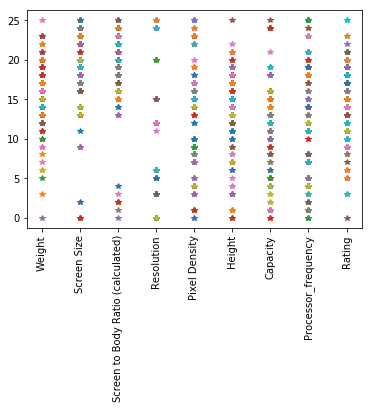

In [26]:
plt.plot(X_bin_train[column_cut_train].T,'*')
plt.xticks(rotation='vertical')
plt.show()

In [27]:
print(rating_threshold)

15


In [28]:
X_bin_train.groupby(X_bin_train['Rating']>=rating_threshold).describe()

os_name_ANDROID                          ...  Brand_YU               
                 count      mean       std  min ...       25%  50%  75%  max
Rating                                          ...                         
False            103.0  0.932039  0.252910  0.0 ...       0.0  0.0  0.0  1.0
True             237.0  0.894515  0.307828  0.0 ...       0.0  0.0  0.0  1.0

[2 rows x 712 columns]

In [29]:
for cols in column_cut_train:
    X_bin_train[cols]=X_bin_train[cols].map(lambda x:1 if x >= rating_threshold else 0)
X_bin_train.head(100)

,Resolution,Processor_frequency,Screen Size,Weight,Height,Capacity,Pixel Density,Screen to Body Ratio (calculated),os_name_ANDROID,os_name_BLACKBERRY,os_name_IOS,os_name_KAI,os_name_NOKIA,os_name_Other,os_name_TIZEN,RAM_0,RAM_1,RAM_2,RAM_3,RAM_4,RAM_6,RAM_8,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Internal Memory_0,Internal Memory_4,Internal Memory_8,Internal Memory_16,Internal Memory_32,Internal Memory_64,Internal Memory_128,Internal Memory_256,Internal Memory_512,SIM 2_2G,SIM 2_3G,...,Brand_GOOGLE,Brand_HONOR,Brand_HTC,Brand_HUAWEI,Brand_INFINIX,Brand_INFOCUS,Brand_INTEX,Brand_ITEL,Brand_IVOOMI,Brand_JIVI,Brand_KARBONN,Brand_LAVA,Brand_LEECO,Brand_LENOVO,Brand_LEPHONE,Brand_LG,Brand_LYF,Brand_MEIZU,Brand_MICROMAX,Brand_MOBIISTAR,Brand_MOTO,Brand_MOTOROLA,Brand_NOKIA,Brand_NUBIA,Brand_ONEPLUS,Brand_OPPO,Brand_PANASONIC,Brand_RAZER,Brand_REALME,Brand_RELIANCE,Brand_SAMSUNG,Brand_SONY,Brand_SPICE,Brand_TECNO,Brand_ULEFONE,Brand_VIVO,Brand_VOTO,Brand_XIAOMI,Brand_YU,Rating
0,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
7,0,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
8,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


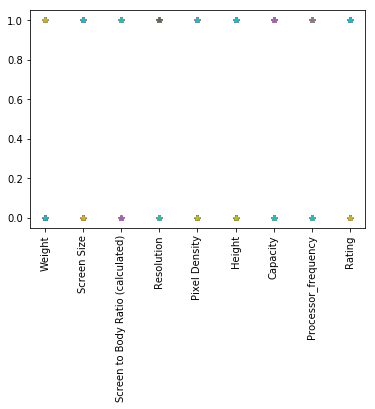

In [30]:
plt.plot(X_bin_train[column_cut_train].T,'*')
plt.xticks(rotation='vertical')
plt.show()

In [31]:
for cols in column_cut_test:
    X_bin_test[cols]=X_bin_test[cols].map(lambda x:1 if x >= rating_threshold else 0)
X_bin_test.head(10)

,Resolution,Processor_frequency,Screen Size,Weight,Height,Capacity,Pixel Density,Screen to Body Ratio (calculated),os_name_ANDROID,os_name_BLACKBERRY,os_name_IOS,os_name_KAI,os_name_NOKIA,os_name_Other,os_name_TIZEN,RAM_0,RAM_1,RAM_2,RAM_3,RAM_4,RAM_6,RAM_8,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Internal Memory_0,Internal Memory_4,Internal Memory_8,Internal Memory_16,Internal Memory_32,Internal Memory_64,Internal Memory_128,Internal Memory_256,Internal Memory_512,SIM 2_2G,SIM 2_3G,...,Brand_GIONEE,Brand_GOOGLE,Brand_HONOR,Brand_HTC,Brand_HUAWEI,Brand_INFINIX,Brand_INFOCUS,Brand_INTEX,Brand_ITEL,Brand_IVOOMI,Brand_JIVI,Brand_KARBONN,Brand_LAVA,Brand_LEECO,Brand_LENOVO,Brand_LEPHONE,Brand_LG,Brand_LYF,Brand_MEIZU,Brand_MICROMAX,Brand_MOBIISTAR,Brand_MOTO,Brand_MOTOROLA,Brand_NOKIA,Brand_NUBIA,Brand_ONEPLUS,Brand_OPPO,Brand_PANASONIC,Brand_RAZER,Brand_REALME,Brand_RELIANCE,Brand_SAMSUNG,Brand_SONY,Brand_SPICE,Brand_TECNO,Brand_ULEFONE,Brand_VIVO,Brand_VOTO,Brand_XIAOMI,Brand_YU
0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [32]:
X_bin_train.groupby(X_bin_train['Rating']).describe()

Brand_10.OR                               ...  os_name_TIZEN                    
             count      mean       std  min  25% ...            min  25%  50%  75%  max
Rating                                           ...                                   
0            103.0  0.019417  0.138662  0.0  0.0 ...            0.0  0.0  0.0  0.0  1.0
1            237.0  0.000000  0.000000  0.0  0.0 ...            0.0  0.0  0.0  0.0  0.0

[2 rows x 776 columns]

In [33]:
column_cut1=list(set(X_bin_train.columns)-set(column_cut_train))
print(column_cut1)

['Brand_GIONEE', 'Brand_GOOGLE', 'Brand_COMIO', 'os_name_BLACKBERRY', 'Brand_XIAOMI', 'os_name_KAI', 'Brand_HUAWEI', 'Num_cores_DUAL', 'Brand_MEIZU', 'RAM_0', 'Brand_COOLPAD', 'Brand_INFINIX', 'Brand_LYF', 'Brand_SAMSUNG', 'Brand_SPICE', 'Brand_DO', 'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE', 'Brand_LAVA', 'Internal Memory_0', 'Num_cores_DECA', 'Num_cores_TRU-OCTA', 'os_name_NOKIA', 'Brand_MICROMAX', 'Brand_KARBONN', 'Brand_NOKIA', 'Internal Memory_128', 'Num_cores_OCTA', 'RAM_3', 'Brand_YU', 'os_name_ANDROID', 'SIM 2_2G', 'SIM Slot(s)_Dual SIM, GSM+GSM', 'Sim1_4G', 'Brand_INTEX', 'Brand_LG', 'Brand_APPLE', 'Brand_RAZER', 'Brand_NUBIA', 'Brand_ITEL', 'SIM Slot(s)_Dual SIM, GSM+CDMA', 'Brand_10.OR', 'SIM Slot(s)_Single SIM, GSM', 'Brand_HONOR', 'Brand_IVOOMI', 'Brand_VOTO', 'Brand_LEECO', 'Brand_LEPHONE', 'Brand_BLACKBERRY', 'Brand_TECNO', 'Brand_PANASONIC', 'Internal Memory_512', 'RAM_2', 'os_name_IOS', 'os_name_Other', 'Brand_ASUS', 'Brand_BILLION', 'Internal Memory_32', 'Brand_SONY'

In [34]:
X_bin_train.head()

,Resolution,Processor_frequency,Screen Size,Weight,Height,Capacity,Pixel Density,Screen to Body Ratio (calculated),os_name_ANDROID,os_name_BLACKBERRY,os_name_IOS,os_name_KAI,os_name_NOKIA,os_name_Other,os_name_TIZEN,RAM_0,RAM_1,RAM_2,RAM_3,RAM_4,RAM_6,RAM_8,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Internal Memory_0,Internal Memory_4,Internal Memory_8,Internal Memory_16,Internal Memory_32,Internal Memory_64,Internal Memory_128,Internal Memory_256,Internal Memory_512,SIM 2_2G,SIM 2_3G,...,Brand_GOOGLE,Brand_HONOR,Brand_HTC,Brand_HUAWEI,Brand_INFINIX,Brand_INFOCUS,Brand_INTEX,Brand_ITEL,Brand_IVOOMI,Brand_JIVI,Brand_KARBONN,Brand_LAVA,Brand_LEECO,Brand_LENOVO,Brand_LEPHONE,Brand_LG,Brand_LYF,Brand_MEIZU,Brand_MICROMAX,Brand_MOBIISTAR,Brand_MOTO,Brand_MOTOROLA,Brand_NOKIA,Brand_NUBIA,Brand_ONEPLUS,Brand_OPPO,Brand_PANASONIC,Brand_RAZER,Brand_REALME,Brand_RELIANCE,Brand_SAMSUNG,Brand_SONY,Brand_SPICE,Brand_TECNO,Brand_ULEFONE,Brand_VIVO,Brand_VOTO,Brand_XIAOMI,Brand_YU,Rating
0,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [35]:
mean_temp = X_bin_train['os_name_KAI'].groupby(X_bin_train['Rating']).sum().values
print(mean_temp)

[2 0]


In [36]:
for cols in X_bin_test.columns:
    mean_temp = X_bin_train[cols].groupby(X_bin_train['Rating']).mean().values
    if (mean_temp[0] - mean_temp[1] > 0):
        X_bin_train[cols] = X_bin_train[cols].map(lambda x:0 if x==1 else 1)
        X_bin_test[cols] = X_bin_test[cols].map(lambda x:0 if x==1 else 1)

In [37]:
X_bin_train.head(30)

,Resolution,Processor_frequency,Screen Size,Weight,Height,Capacity,Pixel Density,Screen to Body Ratio (calculated),os_name_ANDROID,os_name_BLACKBERRY,os_name_IOS,os_name_KAI,os_name_NOKIA,os_name_Other,os_name_TIZEN,RAM_0,RAM_1,RAM_2,RAM_3,RAM_4,RAM_6,RAM_8,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Internal Memory_0,Internal Memory_4,Internal Memory_8,Internal Memory_16,Internal Memory_32,Internal Memory_64,Internal Memory_128,Internal Memory_256,Internal Memory_512,SIM 2_2G,SIM 2_3G,...,Brand_GOOGLE,Brand_HONOR,Brand_HTC,Brand_HUAWEI,Brand_INFINIX,Brand_INFOCUS,Brand_INTEX,Brand_ITEL,Brand_IVOOMI,Brand_JIVI,Brand_KARBONN,Brand_LAVA,Brand_LEECO,Brand_LENOVO,Brand_LEPHONE,Brand_LG,Brand_LYF,Brand_MEIZU,Brand_MICROMAX,Brand_MOBIISTAR,Brand_MOTO,Brand_MOTOROLA,Brand_NOKIA,Brand_NUBIA,Brand_ONEPLUS,Brand_OPPO,Brand_PANASONIC,Brand_RAZER,Brand_REALME,Brand_RELIANCE,Brand_SAMSUNG,Brand_SONY,Brand_SPICE,Brand_TECNO,Brand_ULEFONE,Brand_VIVO,Brand_VOTO,Brand_XIAOMI,Brand_YU,Rating
0,1,0,1,0,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,...,0,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,1,1,1
1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,1,1,...,0,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,1,1,0,1,0,0,0,0,1,0,1,1
2,1,1,1,0,1,1,1,1,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,1,1,...,0,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,1,1,0,1,0,0,0,0,1,0,1,1
3,1,1,1,0,1,0,1,1,0,1,0,1,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,...,0,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,0,1,1,1,0,0,0,0,1,0,1,1
4,1,1,1,0,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,...,0,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,1
5,1,1,1,0,1,0,1,1,0,1,0,1,0,0,1,1,1,0,1,0,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,...,0,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,0,1,0,1,0,0,0,1,1,0,1,1
6,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,1,1,1,1,0,0,0,0,1,1,0,0,1,1,1,1,1,0,1,0,0,0,0,1,1,...,0,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,1,1,1
7,0,0,1,0,0,1,1,1,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,1,1,...,0,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,1,1,1
8,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,1,1,...,0,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,1,1,1,0,1,0,1,0,0,0,0,1,0,1,1
9,1,1,1,0,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,0,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,...,0,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,1,1,1


In [38]:
X_bin_train.shape

(340, 98)

In [39]:
Y_bin_train=X_bin_train['Rating']
X_bin_train=X_bin_train.drop(['Rating'], axis=1)

In [40]:
Y_bin_train.head()

0    1
1    1
2    1
3    1
4    1
Name: Rating, dtype: int64

In [41]:
X_bin_train=X_bin_train.values
Y_bin_train=Y_bin_train.values

In [42]:
print(X_bin_train.shape)

(340, 97)


Value of b:47
Accuracy:0.7588235294117647


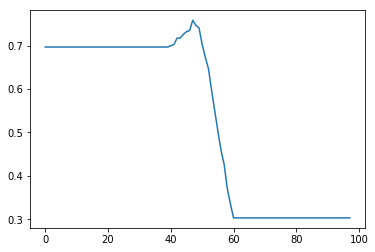

In [43]:
mp_neuron=MPNeuron(1)
mp_neuron.fit(X_bin_train,Y_bin_train)

In [44]:
X_test.shape

(119, 97)

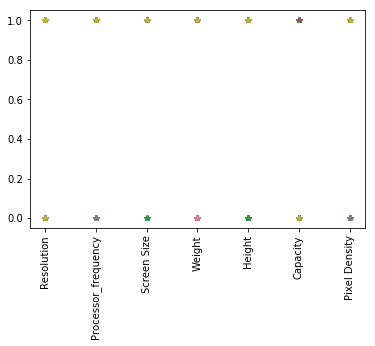

In [45]:
plt.plot(X_bin_test[X_bin_test.columns[0:7]].T,'*')
plt.xticks(rotation='vertical')
plt.show()

In [46]:
X_bin_test=X_bin_test.values
print(X_bin_test.shape)

(119, 97)


In [47]:
Y_test=mp_neuron.predict(X_bin_test)
print(Y_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1
 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0
 1 0 1 1 1 1 1 1]


In [48]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':Y_test})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,1
1,11,1
2,13,1
3,16,1
4,19,1


In [49]:
submission.to_csv("submission.csv", index=False)